## CNN on 15-scene dataset

Download the data from assignment 2.. This had a train and test directory. Each folder has 15 sub-folders corresponding to each category.

**IMPORTANT**: After you have copied the dataset, swap the names of the train and test folder, i.e., the default train folder should be test, and the other is train (the default test folder contains more images, and we want to make sure you have more images for training).

In [36]:
import numpy as np
import skimage
from skimage import io, img_as_float
from skimage.transform import resize

import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
from random import shuffle


### Helper functions to load images

In [37]:
def load_image_gray(path, output_shape):    
    img = io.imread(path) 
    
    #resize image to a fixed size given by output_shape
    image_resized = resize(img, output_shape,
                       anti_aliasing=True)
    return image_resized
    

In [38]:
def get_image_arrays(data_path, categories, output_shape, fmt='jpg'):
    """
    This function returns lists containing the np array for each train
    and test image, as well as lists with the label of each train and
    test image. By default all four of these arrays will have 1500
    elements where each element is a string.
    :param data_path: path to the 'test' and 'train' directories
    :param categories: list of category names
    :param fmt: file extension of the images
    :return: lists: train_image_arrays, test_image_arrays, train_labels, test_labels
    """
    train_image_paths = []
    test_image_paths = []
    train_labels = []
    test_labels = []

    for i, cat in enumerate(categories):
        # train
        pth = osp.join(data_path, 'train', cat, '*.{:s}'.format(fmt))
        pth = glob(pth)

        train_image_paths.extend(pth)
        train_labels.extend([i] * len(pth))

        # test
        pth = osp.join(data_path, 'test', cat, '*.{:s}'.format(fmt))
        pth = glob(pth)

        test_image_paths.extend(pth)
        test_labels.extend([i] * len(pth))

    train_image_arrays = [load_image_gray(p, output_shape) for p in train_image_paths]
    test_image_arrays = [load_image_gray(p, output_shape) for p in test_image_paths]

    return train_image_arrays, test_image_arrays, train_labels, test_labels

In [39]:
# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

### Testing helper function

In [40]:
#THIS TAKES a LONG TIME!!
output_shape = (200, 200)
data_path = osp.join('.', 'data')

train_image_arrays, test_image_arrays, train_labels, test_labels = get_image_arrays(data_path,
                                                                                 categories,
                                                                                output_shape
                                                                               )
if len(train_image_arrays) == 0:
    print(data_path, 'not found')

In [41]:
# ***SAMPLE EXAMPLE*** TO CONVERT IMAGES TO I) NUMPY, II) 0-255 SCALE, III) UINT8 DATATYPE
#Convert to numpy array, bring it back to a 0-255 scale .
train_image_arrays1 = (255 * np.array(train_image_arrays)).astype(np.uint8)
test_image_arrays1 = (255 * np.array(test_image_arrays)).astype(np.uint8)

train_labels1 = np.array(train_labels)
test_labels1 = np.array(test_labels)

print(train_image_arrays1.shape, test_image_arrays1.shape)
print(train_labels1.shape, test_labels1.shape)
print(train_labels1.min(), test_labels1.max())

(2985, 200, 200) (1500, 200, 200)
(2985,) (1500,)
0 14


In [42]:
np.array(np.unique(test_labels, return_counts=True)).T

array([[  0, 100],
       [  1, 100],
       [  2, 100],
       [  3, 100],
       [  4, 100],
       [  5, 100],
       [  6, 100],
       [  7, 100],
       [  8, 100],
       [  9, 100],
       [ 10, 100],
       [ 11, 100],
       [ 12, 100],
       [ 13, 100],
       [ 14, 100]])

## Create a Simple Net

![](simpleNet.jpeg)


In [43]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

**TODO**: RESIZE AS PER THE REQUIREMENT OF THE SIMPLE NET BELOW (DO NOT SCALE back to 255, do not convert to uint8)

In [44]:
#### GRADED CELL ####

#Enter code here to resize your images as per the requirements of the SimpleNet (what's the input dimension?)
#Call the function get_image_arrays with correct output_shape and then convert to numpy array
#Store the final images in train_image_arrays and test_image_arrays (both numpy arrays)
#Store the final labels in train_labels and test_labels (both numpy arrays)

#YOUR CODE HERE
train_image_arrays, test_image_arrays, train_labels, test_labels = get_image_arrays('data', categories, (64,64), fmt='jpg')

train_image_arrays = np.array(train_image_arrays)
test_image_arrays = np.array(test_image_arrays)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [45]:
print(train_image_arrays.shape) #CONFIRM that output is (2985, 64, 64)
print(test_image_arrays.shape) #CONFIRM that output is (1500, 64, 64)

(2985, 64, 64)
(1500, 64, 64)


In [46]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_simple_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should also compile the model with the Adam optimiser, a cross
    entropy loss function (which one? categorical or sparse categorical?), and a single accuracy metric.
    """
    
    model = Sequential([
        Conv2D(filters=10, input_shape=input_shape, kernel_size=(5, 5), activation='relu', name='conv_1'), #layer 1 of 7
        MaxPooling2D(pool_size=(3, 3), name='pool_1'), #layer 2 of 7
        Conv2D(filters=20, input_shape=input_shape, kernel_size=(5, 5), activation='relu', name='conv_2'), #layer 3 of 7
        MaxPooling2D(pool_size=(3, 3), name='pool_2'), #layer 4 of 7
        Flatten(name='flatten'), #layer 5 of 7
        Dense(units=50, activation='relu', name='dense_1'), #layer 6 of 7
        Dense(units=15, activation='softmax', name='dense_2'), #layer 7 of 7
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', #use sparse because we want to categorize the data
                  metrics=['accuracy'])
    
    return model

#### Compile and evaluate the model

In [47]:
# Run your function to create the model

#Add a 1 to the desired input shape (or else Conv2D will complain regarding the expected dimensions)
desired_input_shape = train_image_arrays[0].shape + (1,)
print(desired_input_shape)

model = get_simple_model(desired_input_shape)

(64, 64, 1)


In [48]:
#Print the model summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 60, 60, 10)        260       
                                                                 
 pool_1 (MaxPooling2D)       (None, 20, 20, 10)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 20)        5020      
                                                                 
 pool_2 (MaxPooling2D)       (None, 5, 5, 20)          0         
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                25050     
                                                                 
 dense_2 (Dense)             (None, 15)               

In [49]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

In [50]:
# Calculate its initial test accuracy (without any training)

test_init = get_test_accuracy(model, test_image_arrays, test_labels)

2022-11-11 20:26:35.386160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 0.071


In [51]:
# Train model using the callbacks you just created

#callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
history = model.fit(train_image_arrays, train_labels, epochs=30, validation_data=(test_image_arrays, test_labels)) #, callbacks=callbacks


Epoch 1/30
 5/94 [>.............................] - ETA: 1s - loss: 2.6866 - accuracy: 0.1125 

2022-11-11 20:26:35.918995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 2s 16ms/step - loss: 2.6583 - accuracy: 0.1293 - val_loss: 2.6320 - val_accuracy: 0.1260
Epoch 2/30
94/94 [==============================] - 2s 16ms/step - loss: 2.4587 - accuracy: 0.1896 - val_loss: 2.4249 - val_accuracy: 0.1740
Epoch 3/30
94/94 [==============================] - 2s 16ms/step - loss: 2.2504 - accuracy: 0.2630 - val_loss: 2.2665 - val_accuracy: 0.2473
Epoch 4/30
94/94 [==============================] - 2s 17ms/step - loss: 2.1128 - accuracy: 0.3189 - val_loss: 2.0875 - val_accuracy: 0.3053
Epoch 5/30
94/94 [==============================] - 1s 16ms/step - loss: 1.9284 - accuracy: 0.3685 - val_loss: 1.9675 - val_accuracy: 0.3547
Epoch 6/30
94/94 [==============================] - 1s 15ms/step - loss: 1.8028 - accuracy: 0.4080 - val_loss: 1.9038 - val_accuracy: 0.3673
Epoch 7/30
94/94 [==============================] - 2s 16ms/step - loss: 1.7451 - accuracy: 0.4241 - val_loss: 1.8558 - val_accuracy: 0.3913
Epoch 8/30
94/94 [======

In [52]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

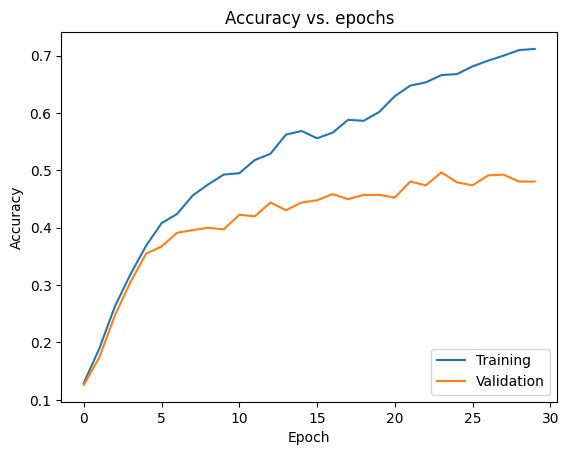

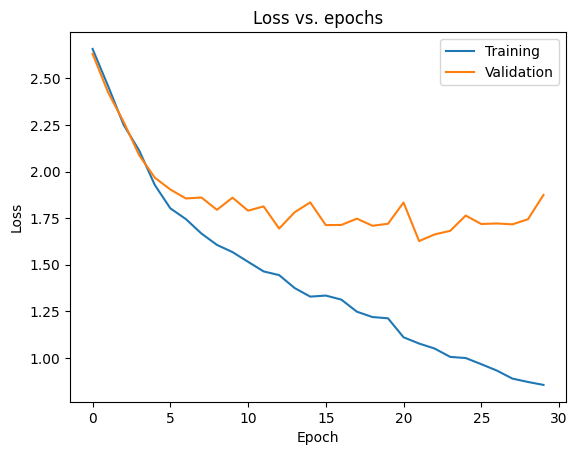

In [53]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(history)
plotLoss(history)


In [54]:
test_first = get_test_accuracy(model, test_image_arrays, test_labels)
#NOTE: You should receive at least 50% accuracy in this step. This will go in the REPORT.
train_first = get_test_accuracy(model, train_image_arrays, train_labels)

accuracy: 0.481
accuracy: 0.708


In [55]:
# Function to Plot confusion matrix

def confMat(model, x_test, y_test):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(x_test)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=categories, columns=categories)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.show()

47/47 [==============================] - 0s 3ms/step


2022-11-11 20:27:20.880817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


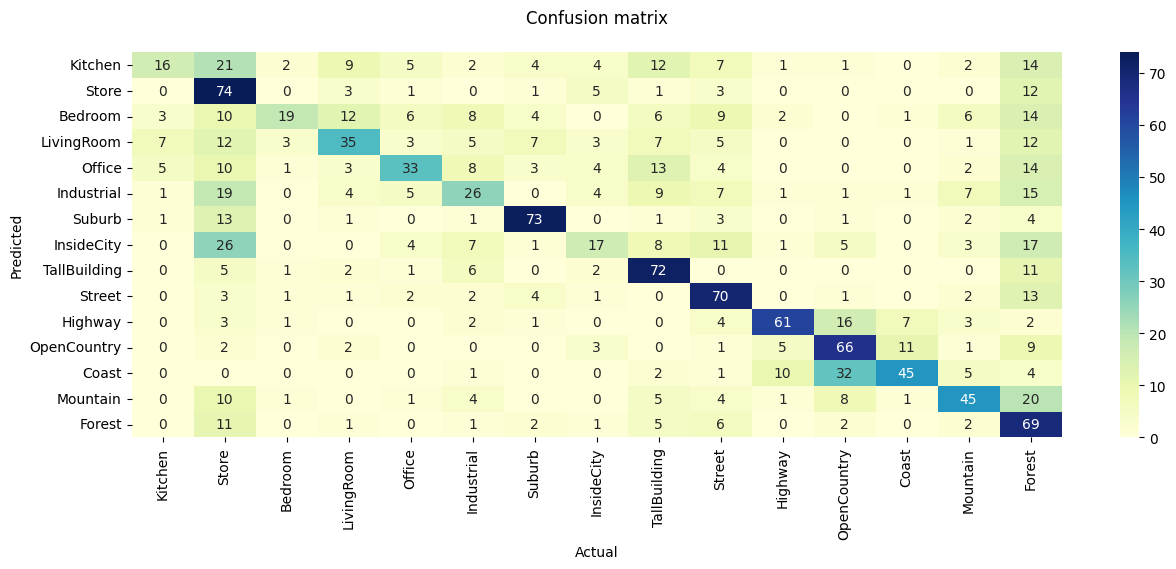

In [56]:
# Plot confusion matrices for model
confMat(model,test_image_arrays, test_labels)
#This will go in the REPORT.

## Regularization
You should have noticed that the training accuracy is VERY HIGH but not so the validation accuracy. Clearly, the network is overfitting. Below, you will write functions to avoid overfitting.

In [57]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_simple_regularized_model(input_shape, wd, rate):
    """
    This function should update the previous mode by incorporating kernel regularization (weight decay),  
    Dropout layer and BatchNormalization layer.
    Your function should also compile the model with the Adam optimiser, a cross
    entropy loss function (which one? categorical or sparse categorical?), and a single accuracy metric.
    """
    model = Sequential([
        Conv2D(filters=10, input_shape=input_shape, kernel_size=(5, 5), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(wd), name='conv_1'),
        BatchNormalization(),
        Dropout(rate),
        MaxPooling2D(pool_size=(3, 3), name='pool_1'),
        BatchNormalization(),
        Conv2D(filters=20, input_shape=input_shape, kernel_size=(5, 5), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(wd), name='conv_2'),
        BatchNormalization(),
        Dropout(rate),
        MaxPooling2D(pool_size=(3, 3), name='pool_2'),
        BatchNormalization(),
        Flatten(name='flatten'),
        Dense(units=100, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(wd), name='dense_1'),
        Dense(units=15, activation='softmax', kernel_regularizer = tf.keras.regularizers.l2(wd), name='dense_2'),
        #BatchNormalization(),
        #Dropout(rate)
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [58]:
#Feel free to update the parameters provided to the function that control the weight decay and drop out rate
regularized_model = get_simple_regularized_model(desired_input_shape,0.0001, 0.2)#1e-5, 0.2)

In [59]:
reg_history = regularized_model.fit(train_image_arrays, train_labels, epochs=30, validation_data=(test_image_arrays, test_labels)) #, callbacks=callbacks


Epoch 1/30
 1/94 [..............................] - ETA: 1:01 - loss: 3.1775 - accuracy: 0.0625

2022-11-11 20:27:21.978921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 2.4013 - accuracy: 0.2439

2022-11-11 20:27:24.284643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 3s 28ms/step - loss: 2.4013 - accuracy: 0.2439 - val_loss: 4.2822 - val_accuracy: 0.0973
Epoch 2/30
94/94 [==============================] - 2s 25ms/step - loss: 1.7223 - accuracy: 0.4369 - val_loss: 5.4754 - val_accuracy: 0.1040
Epoch 3/30
94/94 [==============================] - 2s 26ms/step - loss: 1.3812 - accuracy: 0.5531 - val_loss: 5.9868 - val_accuracy: 0.0720
Epoch 4/30
94/94 [==============================] - 2s 25ms/step - loss: 1.1395 - accuracy: 0.6322 - val_loss: 5.1806 - val_accuracy: 0.0987
Epoch 5/30
94/94 [==============================] - 2s 25ms/step - loss: 0.9433 - accuracy: 0.6951 - val_loss: 4.3503 - val_accuracy: 0.1640
Epoch 6/30
94/94 [==============================] - 2s 25ms/step - loss: 0.7710 - accuracy: 0.7652 - val_loss: 4.4813 - val_accuracy: 0.1727
Epoch 7/30
94/94 [==============================] - 2s 24ms/step - loss: 0.6352 - accuracy: 0.8090 - val_loss: 2.1943 - val_accuracy: 0.3927
Epoch 8/30
94/94 [======

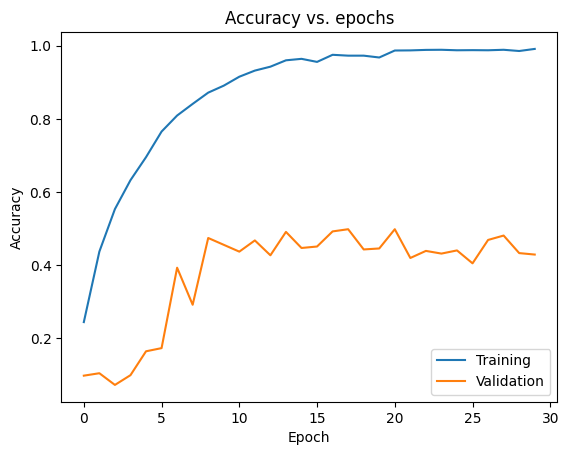

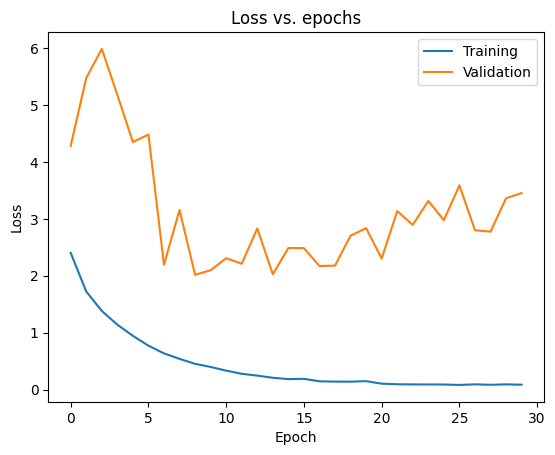

In [60]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(reg_history)
plotLoss(reg_history)

In [61]:
test_reg = get_test_accuracy(regularized_model, test_image_arrays, test_labels)
train_reg = get_test_accuracy(regularized_model, train_image_arrays, train_labels)
#How does the accuracy change with respect to unregularized model. This will go in the REPORT.

accuracy: 0.429
accuracy: 0.798


46/47 [============================>.] - ETA: 0s

2022-11-11 20:28:33.447375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 0s 4ms/step


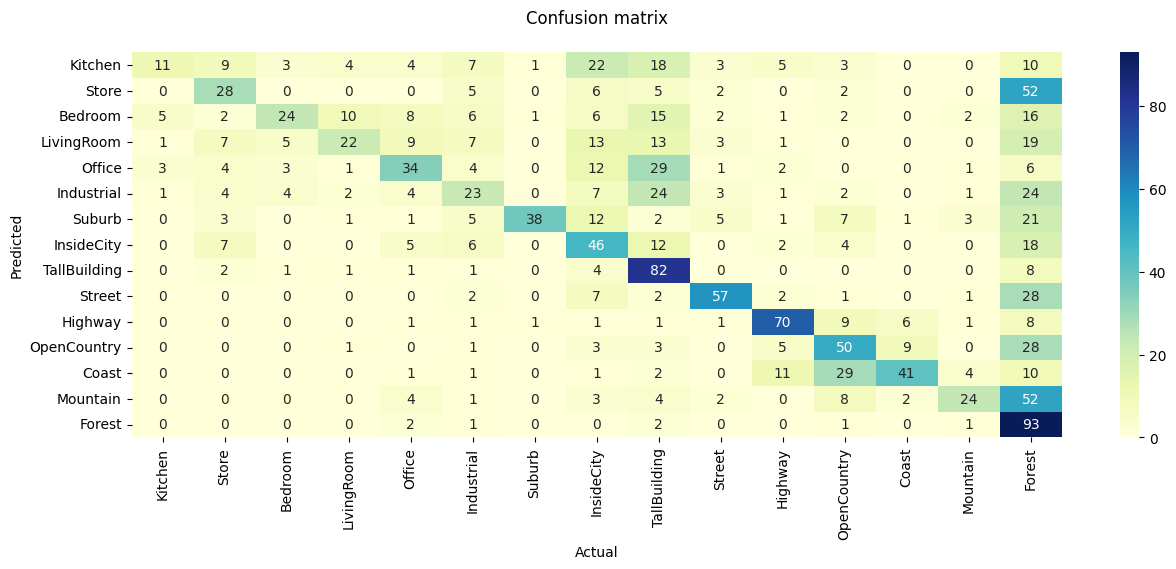

In [62]:
# Plot confusion matrices for model
confMat(regularized_model,test_image_arrays, test_labels)
#This will go in the REPORT.

## Transfer Learning and Fine-tuning using Resnet50

In [63]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from skimage import color

In [64]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.
def load_image_color(path, output_shape): 
    '''
    same as load_image_gray but instead converts the grayscale to rgb image.
    After resizing to output_shape, it scales back to 0-255 and converts to uint8
    '''
    img = io.imread(path)
    img = skimage.color.gray2rgb(img)

    #resize image to a fixed size given by output_shape
    image_resized = resize(img, output_shape,
                   anti_aliasing=True)
    #converts the grayscale to rbg image
    image_rbg = (255 * np.array(image_resized)).astype(np.uint8)

    return image_rbg

In [71]:
#### GRADED CELL ####

#Write function to load the data again but this time calling load_image_color
#Since we will be passing the data to a a Resnet 50 model, make sure that the
#images are of size (64, 64, 3) and are converted to a numpy array

# YOUR CODE HERE
train_image_paths = []
test_image_paths = []
train_labels = []
test_labels = []
output_shape = (64, 64, 3)

for i, cat in enumerate(categories):
    # train
    pth = osp.join(data_path, 'train', cat, '*.{:s}'.format('jpg'))
    pth = glob(pth)

    train_image_paths.extend(pth)
    train_labels.extend([i] * len(pth))

    # test
    pth = osp.join(data_path, 'test', cat, '*.{:s}'.format('jpg'))
    pth = glob(pth)

    test_image_paths.extend(pth)
    test_labels.extend([i] * len(pth))

train_image_arrays = [load_image_color(p, output_shape) for p in train_image_paths]
test_image_arrays = [load_image_color(p, output_shape) for p in test_image_paths]
train_image_arrays = np.array(train_image_arrays)
test_image_arrays = np.array(test_image_arrays)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [66]:
print(train_image_arrays.shape) #CONFIRM that output is (2985, 64, 64, 3)
print(test_image_arrays.shape) #CONFIRM that output is (1500, 64, 64, 3)

(2985, 64, 64, 3)
(1500, 64, 64, 3)


In [75]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_TL_model(input_shape):
    """
    This function will create a model derived from Resnet50. 
        It will include all but the last layer of Resnet50 (essentially the output should have a shape of (None, 2048).
        
        HERE IS THE DIFFERENCE FROM PREVIOUS PART: 
        - DECIDE HOW MANY LAYERS TO ADD. 
        - WHICH LAYERS SHOULD BE TRAINABLE?
        - HOW MANY LAYERS OF THE RESNET 50 SHOULD BE FROZEN?
        
        (You may start with what you have done in the previous part, and iteratively, change some components to test)
    
    Your function should also compile the model with the Adam optimiser, a sparse categorical cross
    entropy loss function, and a single accuracy metric.
    """
    
    ### BEGIN SOLUTION
    
    model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    length_of_resnet = len(model_resnet.layers)

    for i in range((length_of_resnet//4)*3, length_of_resnet):
        model_resnet.layers[i].trainable = False

    new_model = Sequential([
        model_resnet,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.75),
        layers.BatchNormalization(),
        layers.Dense(16, activation='softmax')
    ])
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    new_model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
    )
    
    return new_model
    
    ### END SOLUTION
    

In [76]:
desired_input_shape = train_image_arrays[0].shape
print(desired_input_shape)
model_TL = get_TL_model(desired_input_shape)
model_TL.summary()

(64, 64, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_9 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
Total params: 23,720,144
Trainable params: 7,572,176
Non-trainable params: 16,147,968
______________________

In [77]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_preprocessed_input():
    '''
    Pre-processes the 15-SCENE data using Resnet50 preprocessing function.
    
    Returns the tupple of pre-processed training and test data.
    '''
    ### BEGIN SOLUTION
    
    x_train_resnet = preprocess_input(train_image_arrays)
    x_test_resnet = preprocess_input(test_image_arrays)
    
    return (x_train_resnet, x_test_resnet)
    ### END SOLUTION

In [78]:
train_image_resnet, test_image_resnet = get_preprocessed_input()

In [79]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, mode = 'max', verbose = 1)
new_history = model_TL.fit(train_image_resnet, train_labels, epochs=50, validation_data=(test_image_resnet, test_labels), callbacks=[early_stopping])


Epoch 1/50


2022-11-11 20:37:10.171265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 3.1720 - accuracy: 0.0995

2022-11-11 20:37:24.686298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 19s 163ms/step - loss: 3.1720 - accuracy: 0.0995 - val_loss: 2.4990 - val_accuracy: 0.2167
Epoch 2/50
94/94 [==============================] - 13s 142ms/step - loss: 2.6492 - accuracy: 0.1769 - val_loss: 2.0792 - val_accuracy: 0.3413
Epoch 3/50
94/94 [==============================] - 13s 143ms/step - loss: 2.3395 - accuracy: 0.2603 - val_loss: 1.8648 - val_accuracy: 0.4527
Epoch 4/50
94/94 [==============================] - 13s 142ms/step - loss: 2.1244 - accuracy: 0.3374 - val_loss: 1.7092 - val_accuracy: 0.5160
Epoch 5/50
94/94 [==============================] - 14s 145ms/step - loss: 1.9325 - accuracy: 0.4074 - val_loss: 1.6055 - val_accuracy: 0.5580
Epoch 6/50
94/94 [==============================] - 13s 140ms/step - loss: 1.7747 - accuracy: 0.4710 - val_loss: 1.5022 - val_accuracy: 0.5860
Epoch 7/50
94/94 [==============================] - 13s 138ms/step - loss: 1.6552 - accuracy: 0.5136 - val_loss: 1.4473 - val_accuracy: 0.6280
Epoch 8/50

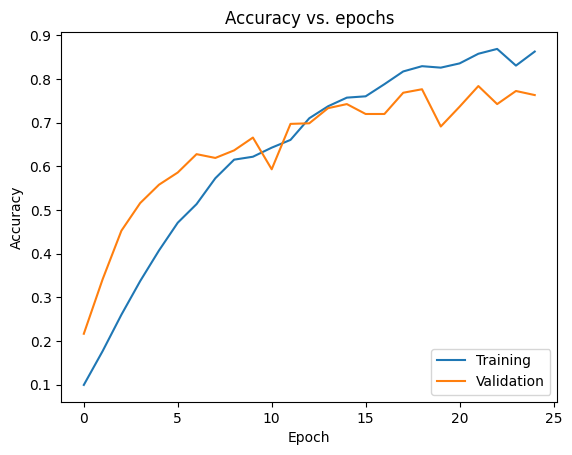

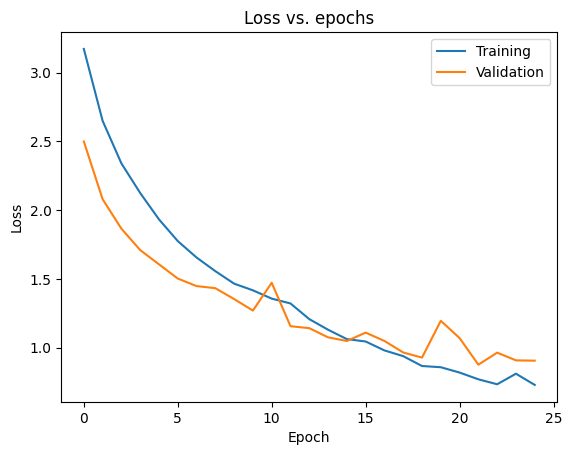

In [80]:
plotAccuracy(new_history)
plotLoss(new_history)

In [81]:
test_first = get_test_accuracy(model_TL, test_image_resnet, test_labels)
train_first = get_test_accuracy(model_TL, train_image_resnet, train_labels)
#NOTE: You should receive at least 75% accuracy in this step. This will go in the REPORT.

accuracy: 0.763
accuracy: 0.975


2022-11-09 15:50:43.082624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 3s 42ms/step


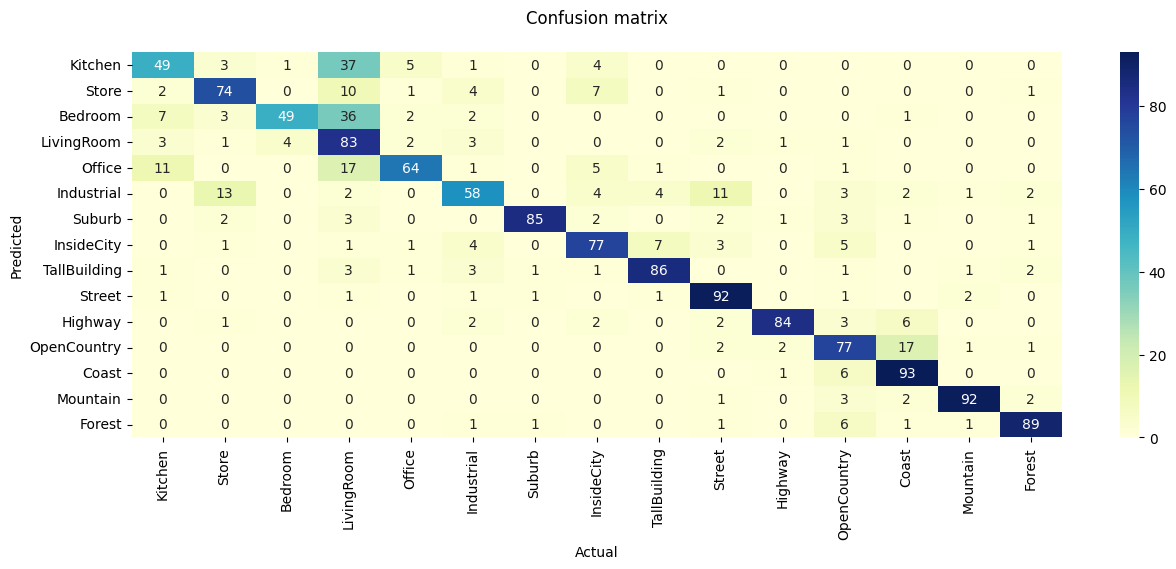

In [ ]:
confMat(model_TL,test_image_resnet, test_labels)
#This will go in the REPORT.

### Improve the performance further. 

Some Ideas: 

1. Use a different pre-trained network such as Xception, InceptionV3
2. Play with how many layers to freeze in the pre-trained network
3. Is the network overfitting? How can you avoid it?


Outcome of these ideas (and any additional you attempted) must be included in the report. Full credit will be given if you get 80% accuracy on this dataset (though getting 90% is also achievable with careful selection of parameters and fine-tuning).

There will be a class-wide competition on which teams gets the higest score and, of course, extra credit is on the table. Stay TUNED!